# NES DCGAN

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-f8e8be0e-770e-396c-55fa-4c91b1d9284d)


## Load Data

In [ ]:
# Mount Google Drive and copy data to VM
from google.colab import drive
drive.mount('/gdrive')

# Extract Data
!cp "/gdrive/My Drive/nesGAN/nes-db.zip" .
!mkdir "data"
!unzip -qq nes-db.zip -d data/nes

# Extract cifar10 features for pre trained model
!cp "/gdrive/My Drive/nesGAN/netD_cifar.pth" .
!cp "/gdrive/My Drive/nesGAN/netG_cifar.pth" .
print("Extracted data into data/nes")

## PyTorch

### Model Parameters

In [ ]:
class AttributeDict(dict): 
    __getattr__ = dict.__getitem__

opt = AttributeDict({
    "dataroot": "data",
    "workers": 4,
    "batchSize": 64,
    "imageSize": 224,
    "nz": 100,
    "ngf": 64, "ndf" : 64,
    "niter": 100,
    "lr": 0.0002,
    "beta1": 0.5,
    "cuda": True,
    "ngpu": 1,
    "netG": "", "netD": "",
    "outf": "/gdrive/My Drive/nesGAN/cache/",
    "manualSeed": False,
})


### Model Definition

In [ ]:
# DCGAN Model modified from
# https://github.com/pytorch/examples/tree/master/dcgan

import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

try:
    os.makedirs(opt.outf)
except OSError:
    pass

if not opt.manualSeed:
    opt.manualSeed = random.randint(1, 10000)

print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

nc=3
dataset = dset.ImageFolder(root=opt.dataroot,
                           transform=transforms.Compose([
                               #transforms.Resize(opt.imageSize),
                               transforms.CenterCrop(opt.imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize,
                                         shuffle=True, num_workers=int(opt.workers))

device = torch.device("cuda:0" if opt.cuda else "cpu")
ngpu = int(opt.ngpu)
nz = int(opt.nz)
ngf = int(opt.ngf)
ndf = int(opt.ndf)

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(      nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.LeakyReLU(inplace=True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16,  ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(inplace=True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d( ngf * 8,  ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(inplace=True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d( ngf * 4,  ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(inplace=True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d( ngf * 2,      ngf, 4, 2, 5, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(inplace=True),
            # state size. (ngf) x 56 x 56
            nn.ConvTranspose2d(     ngf,       nc, 6, 4, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 224 x 224
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.apply(weights_init)
if opt.netG != '':
    netG.load_state_dict(torch.load(opt.netG))
print(netG)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 224 x 224
            nn.Conv2d(     nc,     ndf, 6, 4, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 56 x 56
            nn.Conv2d(    ndf, ndf * 2, 4, 2, 5, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False)#,
            #nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
if opt.netD != '':
    netD.load_state_dict(torch.load(opt.netD))
print(netD)

criterion = nn.BCEWithLogitsLoss()

fixed_noise = torch.randn(opt.batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))

data_size = len(dataloader)

G_losses = []
D_losses = []

for epoch in range(opt.niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)
        output = netD(real_cpu)
        errD_real = criterion(output, label) # ERROR
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch+1, opt.niter, i, data_size, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        if (epoch % 10 == 0 or epoch == opt.niter - 1) and i % min(data_size, 100) == 0:
            vutils.save_image(real_cpu, '%s/real_samples.png' % opt.outf, normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(), '%s/fake_samples_epoch_%03d.png' % (opt.outf, epoch), normalize=True)

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG.pth' % (opt.outf))
    torch.save(netD.state_dict(), '%s/netD.pth' % (opt.outf))

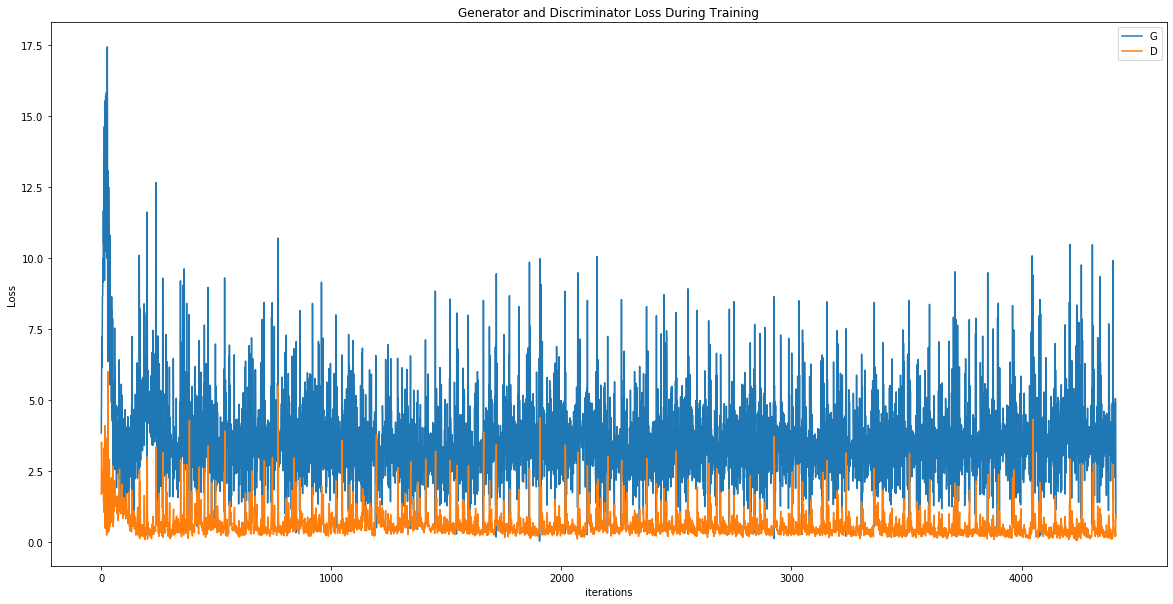

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## PyTorch Pre Trained (cifar10)

### Model Parameters

In [ ]:
class AttributeDict(dict): 
    __getattr__ = dict.__getitem__

opt = AttributeDict({
    "dataroot": "data",
    "workers": 4,
    "batchSize": 64,
    "imageSize": 224,
    "nz": 100,
    "ngf": 64, "ndf" : 64,
    "niter": 200,
    "lr": 0.0002,
    "beta1": 0.5,
    "cuda": True,
    "ngpu": 1,
    "netG": "netG_cifar.pth", "netD": "netD_cifar.pth",
    "outf": "/gdrive/My Drive/nes_cache/",
    "manualSeed": False,
})


### Model Definition

In [ ]:
# DCGAN Model modified from
# https://github.com/csinva/gan-pretrained-pytorch

import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

try:
    os.makedirs(opt.outf)
except OSError:
    pass

if not opt.manualSeed:
    opt.manualSeed = random.randint(1, 10000)

print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

cudnn.benchmark = True

if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

nc=3
dataset = dset.ImageFolder(root=opt.dataroot,
                           transform=transforms.Compose([
                               #transforms.Resize(opt.imageSize),
                               transforms.CenterCrop(opt.imageSize),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

assert dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batchSize,
                                         shuffle=True, num_workers=int(opt.workers))

device = torch.device("cuda:0" if opt.cuda else "cpu")
ngpu = int(opt.ngpu)
nz = int(opt.nz)
ngf = int(opt.ngf)
ndf = int(opt.ndf)


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh(),
            # state size. (ngf) x 32 x 32
            #nn.ConvTranspose2d(ngf    , int(ngf/2), 4, 2, 5, bias=False),
            #nn.BatchNorm2d(int(ngf/2)),
            #nn.ReLU(True),
            # state size. (ngf/2) x 56 x 56
            #nn.ConvTranspose2d(int(ngf/2),      nc, 6, 4, 1, bias=False),
            #nn.Tanh()
            # state size. (nc) x 224 x 224
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.apply(weights_init)
if opt.netG != '':
    netG.load_state_dict(torch.load(opt.netG))

# Fine Tunning

#for param in netG.parameters():
#  param.requires_grad = False

modules = list(netG.main.children())[:-2]
extra = [
  nn.ConvTranspose2d(ngf    , int(ngf/2), 4, 2, 5, bias=False).to(device),
  nn.BatchNorm2d(int(ngf/2)).to(device),
  nn.ReLU(True).to(device),
  nn.ConvTranspose2d(int(ngf/2),      nc, 6, 4, 1, bias=False).to(device),
  nn.Tanh().to(device),
]
for m in extra:
  weights_init(m)
modules.extend(extra)
netG.main = nn.Sequential(*modules)

print(netG)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 224 x 224
            #nn.Conv2d(nc, int(ndf/2), 6, 4, 1, bias=False),
            #nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf/2) x 56 x 56
            #nn.Conv2d(int(ndf/2), ndf, 4, 2, 5, bias=False),
            #nn.BatchNorm2d(ndf),
            #nn.LeakyReLU(0.2, inplace=True),

            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            # nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Conv2d(ndf * 8, 1, 2, 2, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
if opt.netD != '':
    netD.load_state_dict(torch.load(opt.netD))

# Fine Tunning
modules = list(netD.main.children())[2:]
modules[-2] = nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False).to(device)
extra = [
  nn.Conv2d(nc, int(ndf/2), 6, 4, 1, bias=False).to(device),
  nn.LeakyReLU(0.2, inplace=True).to(device),
  nn.Conv2d(int(ndf/2), ndf, 4, 2, 5, bias=False).to(device),
  nn.BatchNorm2d(ndf).to(device),
  nn.LeakyReLU(0.2, inplace=True).to(device),
]
for m in extra:
  weights_init(m)
modules = extra + modules
netD.main = nn.Sequential(*modules)

print(netD)

criterion = nn.BCELoss()

fixed_noise = torch.randn(opt.batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))

data_size = len(dataloader)

G_losses = []
D_losses = []

for epoch in range(opt.niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)
        output = netD(real_cpu)
        errD_real = criterion(output, label) # ERROR
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch+1, opt.niter, i, data_size,
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if (epoch % 10 == 0 or epoch == opt.niter - 1) and i % min(data_size, 100) == 0:
            vutils.save_image(real_cpu, '%s/real_samples.png' % opt.outf, normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(), '%s/fake_samples_epoch_%03d.png' % (opt.outf, epoch), normalize=True)

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG.pth' % (opt.outf))
    torch.save(netD.state_dict(), '%s/netD.pth' % (opt.outf))

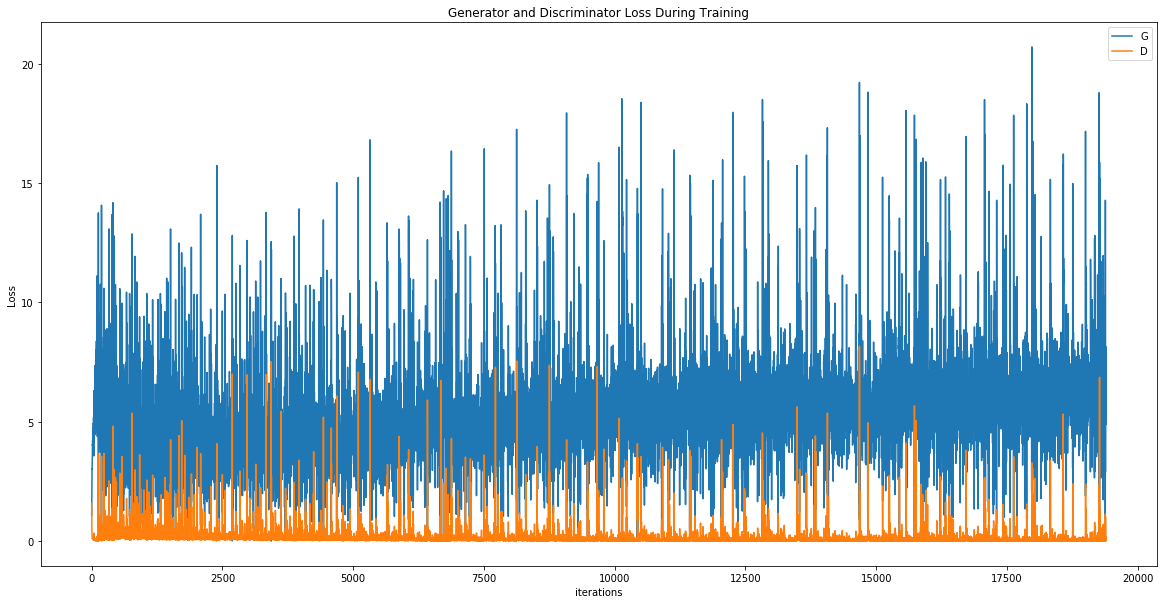

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()